# Fine Tune Llama-3.2-3B 

In [3]:
%%capture
%pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
%pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
%pip install --no-deps unsloth

In [ ]:
import wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wb_token = user_secrets.get_secret("wandb")

wandb.login(key=wb_token)
run = wandb.init(
    project='Clinical-Llama-3.2-3B', 
    job_type="training", 
    anonymous="allow"
)

In [31]:
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

hf_token = user_secrets.get_secret("HUGGINGFACE_TOKEN")
login(hf_token)

## Load Model

In [7]:
from unsloth import FastLanguageModel
import torch
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported
from unsloth.chat_templates import train_on_responses_only

def load_model_and_tokenizer(max_seq_length=2048, dtype=None, load_in_4bit=True):
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name="unsloth/Llama-3.2-3B-Instruct",
        max_seq_length=max_seq_length,
        dtype=dtype,
        load_in_4bit=load_in_4bit,
    )
    return model, tokenizer

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-05-16 02:54:11.382840: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747364051.559935      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747364051.610494      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🦥 Unsloth Zoo will now patch everything to make training faster!


## Apply Lora

In [8]:
def apply_lora(model):
    model = FastLanguageModel.get_peft_model(
        model,
        r=16,
        target_modules=["q_proj", "k_proj", "v_proj", "o_proj",
                        "gate_proj", "up_proj", "down_proj"],
        lora_alpha=16,
        lora_dropout=0.1,
        bias="none",
        use_gradient_checkpointing="unsloth",
        random_state=3407,
        use_rslora=False,
        loftq_config=None,
    )
    return model

## Train Model Parameters

In [9]:
from transformers import EarlyStoppingCallback, TextStreamer, TrainingArguments

def create_trainer(model, tokenizer, train_dataset,eval_dataset, training_args):
    callbacks = [
        EarlyStoppingCallback(training_args["early_stopping_patience"]),
    ]

    args = TrainingArguments(
        per_device_train_batch_size=training_args["per_device_train_batch_size"],
        per_device_eval_batch_size=training_args["per_device_eval_batch_size"],
        gradient_accumulation_steps=training_args["gradient_accumulation_steps"],
        logging_steps=training_args["logging_steps"],
        output_dir=training_args["output_dir"],
        save_strategy = "steps",
        save_steps=training_args["save_steps"],     ## Fine tuning from last checkpoint
        warmup_steps=training_args["warmup_steps"],
        num_train_epochs=training_args["num_train_epochs"],
        learning_rate=training_args["learning_rate"],
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        weight_decay=training_args["weight_decay"],
        lr_scheduler_type=training_args["lr_scheduler_type"],
        seed=training_args["seed"],
        report_to=training_args["report_to"],            ## wandb if want metrics
        optim=training_args["optim"],

        # ✅ Fields related to Validation loss:
        eval_strategy=training_args["eval_strategy"],
        eval_steps=training_args["eval_steps"],
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",  # Or "eval_accuracy", depending on your metric
        greater_is_better=False,
    )

    trainer = SFTTrainer(
        model=model,
        tokenizer=tokenizer,
        train_dataset= train_dataset, 
        eval_dataset= eval_dataset,
        dataset_text_field=training_args["dataset_text_field"],
        max_seq_length=training_args["max_seq_length"],
        data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer),
        dataset_num_proc=training_args["dataset_num_proc"],
        packing=training_args["packing"],
        args=args,
        callbacks=callbacks
    )

    trainer = train_on_responses_only(
        trainer,
        instruction_part=training_args["instruction_part"],
        response_part=training_args["response_part"],
    )
    return trainer


In [10]:
def train_model(trainer):
    return trainer.train()

## Run Model

In [11]:
def run_model(model, tokenizer, instruction, query):
    FastLanguageModel.for_inference(model)
    messages = [
        {"role": "system", "content": instruction},
        {"role": "user", "content": query},
    ]
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer(prompt, return_tensors='pt', padding=True, truncation=True).to("cuda")
    outputs = model.generate(**inputs, max_new_tokens=1500, num_return_sequences=1)
    text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return text

## Preprocessing Data

In [12]:
def visualize_data(df):
    print("Shape:", df.shape)
    print("Columns:", df.columns.tolist())
    print("\nData Types and Non-Null Info:")
    print(df.info())
    print("-" * 50)

    # Null value check
    print("Null values:\n", df.isna().sum())
    print("-" * 50)

    # Duplicate rows
    print("Duplicate rows:", df.duplicated().sum())
    print("-" * 50)


In [13]:
from unsloth.chat_templates import get_chat_template
from datasets import Dataset

instruction = """You are a helpful and knowledgeable medical expert. You provide clear, accurate, and empathetic answers to health-related questions based on current medical guidelines and research. You should be always respectful to individual concerns, and prioritize patient safety."""

def format_chat_template(row):

    row_json = [{"role": "system", "content": instruction },
               {"role": "user", "content": row['input']},
               {"role": "assistant", "content": row['output']}]
    
    row["text"] = tokenizer.apply_chat_template(row_json, tokenize=False)
    return row

## Load Dataset

In [14]:
from datasets import load_dataset
dataset = load_dataset("InferenceLab/medical_qa_mediqa")
### split test and train
split_dataset = dataset['train'].train_test_split(test_size=0.2, seed=42)
df_train = split_dataset["train"]
df_test = split_dataset["test"]
print(df_train)
print(df_test)

README.md:   0%|          | 0.00/653 [00:00<?, ?B/s]

medical_meadow_mediqa.json:   0%|          | 0.00/15.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2208 [00:00<?, ? examples/s]

Dataset({
    features: ['output', 'input', 'instruction'],
    num_rows: 1766
})
Dataset({
    features: ['output', 'input', 'instruction'],
    num_rows: 442
})


## Train Dataset

In [15]:
df = df_train.to_pandas()
visualize_data(df)
df.head()

Shape: (1766, 3)
Columns: ['output', 'input', 'instruction']

Data Types and Non-Null Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1766 entries, 0 to 1765
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   output       1766 non-null   object
 1   input        1766 non-null   object
 2   instruction  1766 non-null   object
dtypes: object(3)
memory usage: 41.5+ KB
None
--------------------------------------------------
Null values:
 output         0
input          0
instruction    0
dtype: int64
--------------------------------------------------
Duplicate rows: 106
--------------------------------------------------


,output,input,instruction
0,Endometriosis is when the kind of tissue that ...,What is Endometriosis?: Endometriosis is a pro...,How bad can endometriosis get?
1,The causes of obsessive-compulsive disorder ar...,Obsessive-compulsive disorder (OCD) (Causes): ...,what is the cause of ocd
2,The risk of lung cancer is increased by smokin...,Lung cancer (Causes): Lung cancer is the deadl...,how to prevent lung cancer
3,Oleander poisoning occurs when someone eats th...,Oleander poisoning Rosebay poisoning Yellow o...,If oleandor was ingested by touching the plant...
4,Pulmonary hypertension is a type of high blood...,Pulmonary hypertension: Pulmonary hypertension...,what are the causes of pulmonary hypertension


In [16]:
# 1. Load model and tokenizer
model, tokenizer = load_model_and_tokenizer()

==((====))==  Unsloth 2025.5.4: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    Tesla P100-PCIE-16GB. Num GPUs = 1. Max memory: 15.888 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 6.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.35G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.7k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

In [17]:
train_dataset = df_train.map(
    format_chat_template,
    num_proc= 4,
)
print(len(train_dataset), train_dataset["text"][0])

Map (num_proc=4):   0%|          | 0/1766 [00:00<?, ? examples/s]

1766 <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 16 May 2025

You are a helpful and knowledgeable medical expert. You provide clear, accurate, and empathetic answers to health-related questions based on current medical guidelines and research. You should be always respectful to individual concerns, and prioritize patient safety.<|eot_id|><|start_header_id|>user<|end_header_id|>

What is Endometriosis?: Endometriosis is a problem affecting a woman's uterus - the place where a baby grows when she's pregnant. Endometriosis is when the kind of tissue that normally lines the uterus grows somewhere else. It can grow on the ovaries, behind the uterus or on the bowels or bladder. Rarely, it grows in other parts of the body.     This "misplaced" tissue can cause pain, infertility, and very heavy periods. The pain is usually in the abdomen, lower back or pelvic areas. Some women have no symptoms at all. Having trouble getting pre

## Test Data

In [18]:
test_dataset = df_test.map(
    format_chat_template,
    num_proc= 4,
)
print(len(test_dataset), test_dataset["text"][1])

Map (num_proc=4):   0%|          | 0/442 [00:00<?, ? examples/s]

442 <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 16 May 2025

You are a helpful and knowledgeable medical expert. You provide clear, accurate, and empathetic answers to health-related questions based on current medical guidelines and research. You should be always respectful to individual concerns, and prioritize patient safety.<|eot_id|><|start_header_id|>user<|end_header_id|>

What is Hepatitis C?: Your liver is the largest organ inside your body. It helps your body digest food, store energy, and remove poisons. Hepatitis is an inflammation of the liver. One type, hepatitis C, is caused by the hepatitis C virus (HCV). It usually spreads through contact with infected blood. It can also spread through sex with an infected person and from mother to baby during childbirth.    Most people who are infected with hepatitis C don't have any symptoms for years. If you do get symptoms, you may feel as if you have the flu. You may

## Set Model and Trainer

In [19]:
# 1. Load model and tokenizer
model, tokenizer = load_model_and_tokenizer()

# 2. Apply LoRA
model = apply_lora(model)

==((====))==  Unsloth 2025.5.4: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    Tesla P100-PCIE-16GB. Num GPUs = 1. Max memory: 15.888 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 6.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.1.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2025.5.4 patched 28 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


In [21]:
# 3. Create trainer
training_args = {
    "per_device_eval_batch_size": 6,  ## test batch size should fit in GPU ## all batches get tested at once
    "per_device_train_batch_size": 6,  ## train batch size should fit in GPU
    "gradient_accumulation_steps": 4,
    "eval_strategy": "steps",
    "eval_steps": 5,
    "early_stopping_patience": 3,
    "logging_steps": 1,
    "save_steps": 10,                  ## total steps = (len(train_dataset)//(per_device_train_batch_size*gradient_accumulation_steps))  
    "warmup_steps": 5,
    "num_train_epochs": 1,
    "learning_rate": 1e-5,
    "weight_decay": 0.01,
    "lr_scheduler_type": "linear",
    "seed": 3407,
    "output_dir": "outputs",
    "report_to": "none",               ## use for wandb etc
    "optim": "adamw_8bit",
    "max_seq_length": 2048,
    "dataset_num_proc": 2,
    "packing": False,
    "dataset_text_field": "text",
    "instruction_part": "<|start_header_id|>user<|end_header_id|>\n\n",
    "response_part": "<|start_header_id|>assistant<|end_header_id|>\n\n",
}

trainer = create_trainer(model, tokenizer, train_dataset, test_dataset, training_args)


## Begin Training

In [22]:
# 4. Train model
trainer_stats = train_model(trainer)

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,766 | Num Epochs = 1 | Total steps = 73
O^O/ \_/ \    Batch size per device = 6 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (6 x 4 x 1) = 24
 "-____-"     Trainable parameters = 24,313,856/3,000,000,000 (0.81% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
5,0.452700,0.651569
10,0.510900,0.632964
15,0.711500,0.610084
20,0.739800,0.588070
25,0.508800,0.568010
30,0.444500,0.550989
35,0.430000,0.536877
40,0.403900,0.525322
45,0.500000,0.515921
50,0.429700,0.508760


Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


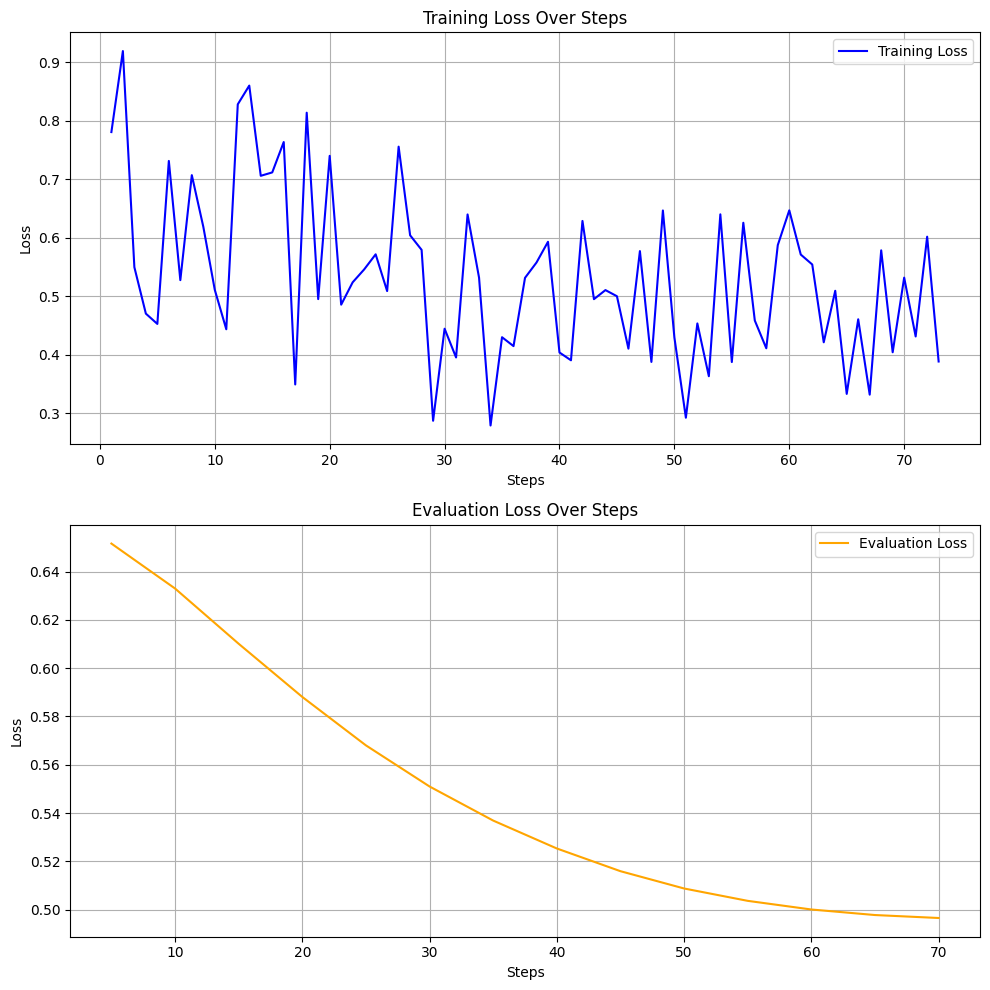

In [34]:
import matplotlib.pyplot as plt

# Collect logs
logs = trainer.state.log_history

# Initialize lists for plotting
train_loss = []
eval_loss = []
eval_steps = []
train_steps = []

# Extract values from logs
for entry in logs:
    if 'loss' in entry and 'step' in entry:
        train_loss.append(entry['loss'])
        train_steps.append(entry['step'])
    if 'eval_loss' in entry:
        eval_loss.append(entry['eval_loss'])
        eval_steps.append(entry['step'])

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot Training Loss
axs[0].plot(train_steps, train_loss, color='blue', label="Training Loss")
axs[0].set_title("Training Loss Over Steps")
axs[0].set_xlabel("Steps")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid(True)

# Plot Evaluation Loss
axs[1].plot(eval_steps, eval_loss, color='orange', label="Evaluation Loss")
axs[1].set_title("Evaluation Loss Over Steps")
axs[1].set_xlabel("Steps")
axs[1].set_ylabel("Loss")
axs[1].legend()
axs[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


## Save the Lora Adaptor Locally

In [ ]:
model.save_pretrained("MediLlama-3.2-LoraAdaptors")  
tokenizer.save_pretrained("MediLlama-3.2-LoraAdaptors")

config.json:   0%|          | 0.00/1.55k [00:00<?, ?B/s]

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/tokenizer.json')

## Save Lora Adaptor to Hugging Hub

In [ ]:
model.push_to_hub("your_username/MediLlama-3.2-LoraAdaptors", token = hf_token) # Online saving
tokenizer.push_to_hub("your_username/MediLlama-3.2-LoraAdaptors", token = hf_token) # Online saving

## Merge Lora Adaptor with base model and save to Hub

In [ ]:
# Merge to 16bit
model.save_pretrained_merged("MediLlama-3.2", tokenizer, save_method = "merged_16bit",)
model.push_to_hub_merged("your_username/MediLlama-3.2", tokenizer, save_method = "merged_16bit", token = hf_token)